## Building a model to check the work of volunteers
To find out, answer the following questions:
* Do title length, article length, or average length of words play a role in an article's popularity?
    * Hypothesis: Shorter articles with shorter titles and shorter words (simpler vocabulary) will garner more shares on average.
* Do certain genres lead to more popular articles? 
    * Hypothesis: Certain genres will receive more shares on average.
* What effect does the day of publication have?
    * Hypothesis: The day of publication will not have an impact on an article's shares.
* Do articles that skew positive, negative, or neutral perform better?
    * Hypothesis: More negative, outrageous (higher subjectivity) articles will be shared more on average.
* What effect do SEO terms have?
    * Hypothesis: Better performing SEO terms (keywords) will have a positive impact on an article's shares.
    
## Approach
Using UCI's [Online News Popularity Data Set](http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity), I perform statistical tests to measure the significance of certain variables on the number of social media shares an article receives. During my exploratory data analysis, I create graphs that answer some of my objective questions. I then create a linear regression model, from which I can infer the strongest predictors based on the coefficients within the model.

## Cleaning and exploring the data
* Import the necessary libraries.

In [63]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
import folium
import geopandas as gpd

import pickle

from functions import *
%load_ext autoreload
%autoreload 2

from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import BallTree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import itertools

import warnings
warnings.filterwarnings('ignore')

# POSSIBLY
from collections import Counter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* Import the data and take a look.

In [85]:
trees_initial = pd.read_csv('data/2015StreetTreesCensus_TREES.csv')
trees_initial.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [86]:
trees_initial.shape

(683788, 42)

In [87]:
trees_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  683788 non-null  object 
 1   tree_id     683788 non-null  int64  
 2   block_id    683788 non-null  int64  
 3   the_geom    683788 non-null  object 
 4   tree_dbh    683788 non-null  int64  
 5   stump_diam  683788 non-null  int64  
 6   curb_loc    683788 non-null  object 
 7   status      683788 non-null  object 
 8   health      652172 non-null  object 
 9   spc_latin   652169 non-null  object 
 10  spc_common  652169 non-null  object 
 11  steward     652173 non-null  object 
 12  guards      652172 non-null  object 
 13  sidewalk    652172 non-null  object 
 14  user_type   683788 non-null  object 
 15  problems    652124 non-null  object 
 16  root_stone  683788 non-null  object 
 17  root_grate  683788 non-null  object 
 18  root_other  683788 non-null  object 
 19  tr

In [88]:
trees_initial.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,6.837880e+05,683788.000000,683788.000000,6.837880e+05,683788.000000
mean,365205.011085,313793.096236,11.279787,0.432463,10916.246044,343.505404,3.358500,29.943181,50.791583,20.615781,3.404914e+06,40.701261,-73.924060,1.005280e+06,194798.424624
std,208122.092902,114839.024312,8.723042,3.290241,651.553364,115.740601,1.166746,14.328531,18.966520,7.390844,1.175863e+06,0.090311,0.123583,3.428505e+04,32902.061114
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792223
25%,186582.750000,221556.000000,4.000000,0.000000,10451.000000,302.000000,3.000000,19.000000,33.000000,14.000000,3.011700e+06,40.631928,-73.980500,9.896578e+05,169515.153719
50%,366214.500000,319967.000000,9.000000,0.000000,11214.000000,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700612,-73.912911,1.008386e+06,194560.252497
75%,546170.250000,404624.000000,16.000000,0.000000,11365.000000,412.000000,4.000000,43.000000,64.000000,25.000000,4.103202e+06,40.762228,-73.834910,1.029991e+06,217019.571916
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092088


* Rename some columns.

In [89]:
trees_initial.columns = ['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'latitude',
       'longitude', 'x_sp', 'y_sp']

* Remove stumps and dead trees.

In [90]:
trees_initial.status.value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [91]:
# Get indices of dead trees and stumps
dead = trees_initial[trees_initial.status.isin(['Dead', 'Stump'])].index
 
# Delete these row indices from dataFrame
trees_initial.drop(dead, inplace=True)

trees_initial.shape

(652173, 42)

* Drop some unneccesary columns and set the index to the **tree_id**.

In [92]:
drop_cols = ['created_at', 'the_geom', 'stump_diam', 'status', 'spc_latin', 'problems', 'address', 'zipcode',
             'zip_city', 'borocode', 'boro_ct', 'state', 'x_sp', 'y_sp']
trees_initial.drop(columns=drop_cols, inplace=True)
trees_initial.set_index(['tree_id'], inplace=True)
trees_initial.shape

(652173, 27)

* Save a copy.

In [93]:
# uncomment to save
# trees_initial.to_csv('data/nyc_trees_2015_initial_clean.csv')

In [111]:
trees = pd.read_csv('data/nyc_trees_2015_initial_clean.csv', index_col=0)
trees.head()

,block_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,root_stone,...,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,nta_name,latitude,longitude
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,348711,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,...,No,406,Queens,29,28,16,QN17,Forest Hills,40.723092,-73.844215
200540,315986,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,...,No,407,Queens,19,27,11,QN49,Whitestone,40.794111,-73.818679
204026,218365,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,...,No,301,Brooklyn,34,50,18,BK90,East Williamsburg,40.717581,-73.936608
204337,217969,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,...,No,301,Brooklyn,34,53,18,BK90,East Williamsburg,40.713537,-73.934456
189565,223043,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,...,No,306,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,40.666778,-73.975979


## Feature engineering and EDA

* Look for NaN values.

In [112]:
trees.isna().sum()

block_id        0
tree_dbh        0
curb_loc        0
health          1
spc_common      5
steward         0
guards          1
sidewalk        1
user_type       0
root_stone      0
root_grate      0
root_other      0
trunk_wire      0
trunk_light     0
trunk_other     0
branch_light    0
branch_shoe     0
branch_other    0
cb_num          0
boroname        0
council_dist    0
st_assem        0
st_senate       0
nta             0
nta_name        0
latitude        0
longitude       0
dtype: int64

* Drop the few rows with missing values for our target variable and species of tree.

In [113]:
trees.dropna(how='any', axis=0, inplace=True)

* Create and pickle a dictionary of neighborhood codes and names, in case we want that later.

In [114]:
nta = list(trees['nta'].unique())

In [115]:
nta_name = list(trees['nta_name'].unique())

In [116]:
nta_dict = {k: v for k,v in zip(nta, nta_name)}

In [117]:
# with open('data/nta_dict.pickle', 'wb') as f:
#     pickle.dump(nta_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

* We want to build a model based on the professional entries, so let's drop all of the volunteer entries.
    * Before we do that, however, we want to create a variable to see if the amount of trees on a block has any relationship to the health of trees. Doing this before dropping volunteers give us the most accurate block count.

In [118]:
trees.block_id.value_counts().unique()

array([440, 356, 241, 206, 194, 176, 148, 145, 136, 124, 121, 118, 115,
       108, 104, 103, 102,  99,  96,  92,  91,  89,  88,  86,  85,  83,
        80,  78,  77,  76,  75,  74,  72,  71,  70,  69,  68,  67,  65,
        64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,
        51,  50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

In [119]:
# create a column with the total count of the trees on that row's block
block_counts = trees.block_id.value_counts().rename('block_count')

# merge onto dataframe
trees = trees.merge(block_counts.to_frame(),
                                left_on='block_id',
                                right_index=True)

trees.block_count.unique()

array([ 15,  21,   4,  24,   5,   3,  14,  11,   7,  13,   8,  20,  12,
        16,  10,   2,   6,   9,  60,  19,  43,  18,  17,  27,   1,  42,
        29,  25,  46,  22,  23,  34,  26,  67,  72,  31, 103,  38,  41,
        49, 104, 440,  37,  32,  63,  28,  36,  69, 194,  53,  47,  35,
        48,  44,  33,  30, 136,  55,  39,  58,  45, 145,  77,  40,  68,
        50,  64,  99,  92,  62,  61,  59,  88, 124,  80,  52,  51,  83,
        74, 148, 241,  56,  75,  54,  57, 176,  70, 206, 356,  86,  78,
        71,  96, 108, 121,  89,  76,  85, 115, 118,  65, 102,  91])

In [120]:
trees.block_count.describe()

count    652166.000000
mean         12.376858
std          18.846467
min           1.000000
25%           5.000000
50%           9.000000
75%          15.000000
max         440.000000
Name: block_count, dtype: float64

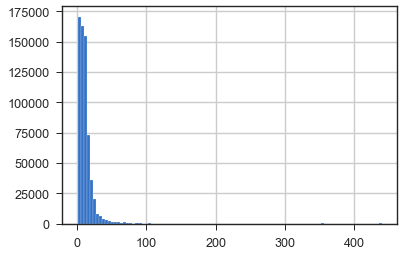

In [121]:
trees.block_count.hist(bins=100)

In [122]:
trees['log_block_count'] = trees.block_count.apply(lambda x: np.log(x))

In [123]:
trees.log_block_count.describe()

count    652166.000000
mean          2.178280
std           0.778605
min           0.000000
25%           1.609438
50%           2.197225
75%           2.708050
max           6.086775
Name: log_block_count, dtype: float64

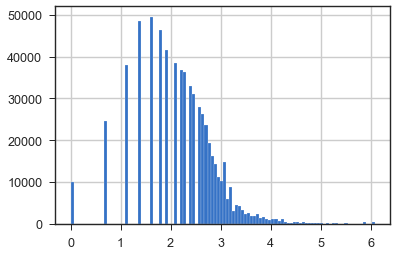

In [124]:
trees.log_block_count.hist(bins=100)

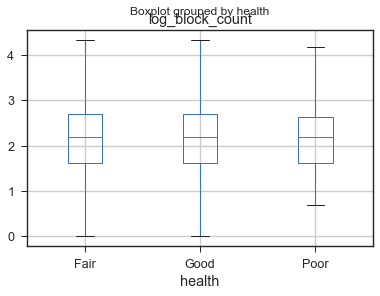

In [126]:
trees.boxplot('log_block_count', 'health', showfliers=False)

* Our new feature doesn't look too promising, but we'll see how high it's p-value is later.

* On to dropping those volunteers:
    * Notice too that volunteers tend to rate fewer trees as 'Good' and more as 'Fair'. Perhaps a result of lack of training.

In [127]:
trees.user_type.value_counts()

TreesCount Staff    282254
Volunteer           207776
NYC Parks Staff     162136
Name: user_type, dtype: int64

In [128]:
trees.groupby('user_type').health.value_counts(normalize=True)

user_type         health
NYC Parks Staff   Good      0.824314
                  Fair      0.131094
                  Poor      0.044592
TreesCount Staff  Good      0.814656
                  Fair      0.148069
                  Poor      0.037275
Volunteer         Good      0.795347
                  Fair      0.161020
                  Poor      0.043634
Name: health, dtype: float64

In [129]:
# Get indices of volunteer
volunteers = trees[trees.user_type == 'Volunteer'].index
 
# Delete these row indices from dataFrame
trees.drop(volunteers, inplace=True)

trees.shape

(444390, 29)

* Let's go ahead and drop some more unnecessary columns.

In [130]:
trees.columns

Index(['block_id', 'tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'root_stone', 'root_grate',
       'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'cb_num', 'boroname',
       'council_dist', 'st_assem', 'st_senate', 'nta', 'nta_name', 'latitude',
       'longitude', 'block_count', 'log_block_count'],
      dtype='object')

In [131]:
drop_cols = ['block_id', 'user_type', 'nta_name', 'latitude', 'longitude', 'block_count']
trees.drop(columns=drop_cols, inplace=True)
trees.shape

(444390, 23)

In [132]:
trees.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,...,branch_light,branch_shoe,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,log_block_count
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805
180679,3,OnCurb,Good,Callery pear,None,None,Damage,No,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805
180669,12,OnCurb,Fair,crimson king maple,None,None,NoDamage,No,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805
180677,13,OnCurb,Good,littleleaf linden,None,None,NoDamage,Yes,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805
180682,5,OnCurb,Fair,eastern redbud,None,None,NoDamage,No,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805


* Take a look at our target variable.

In [133]:
trees.health.value_counts()

Good    363591
Fair     63048
Poor     17751
Name: health, dtype: int64

In [134]:
trees.health.value_counts(normalize=True)

Good    0.818180
Fair    0.141875
Poor    0.039945
Name: health, dtype: float64

* Since we only have two continuous variables (tree diameter and block count), let's go ahead and rein in the extreme values on that now.

In [135]:
trees.tree_dbh.describe()

count    444390.000000
mean         11.908191
std           8.831671
min           0.000000
25%           5.000000
50%          10.000000
75%          17.000000
max         425.000000
Name: tree_dbh, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13770d208>]],
      dtype=object)

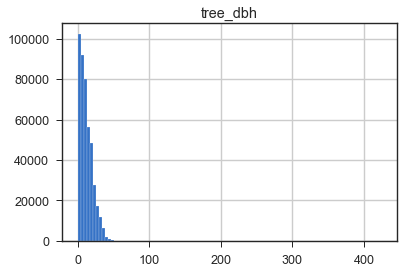

In [136]:
trees.hist('tree_dbh', bins=100)

In [138]:
rein_extremes(trees, ['tree_dbh', 'log_block_count'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14b5d84e0>]],
      dtype=object)

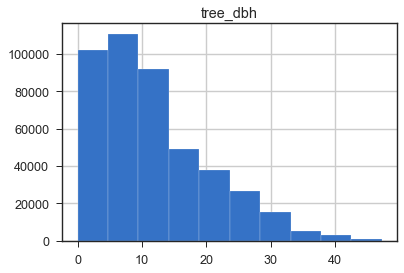

In [139]:
trees.hist('tree_dbh', bins=10)

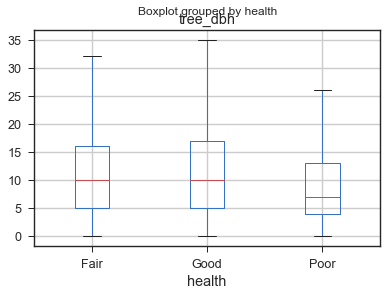

In [179]:
trees.boxplot('tree_dbh', 'health', showfliers=False)

* Tree diameter looks like a promising feature, as thinner trees tend to be in poor health as compared to thicker trees. Not much difference between trees in good and fair health, however.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x142fa3e80>]],
      dtype=object)

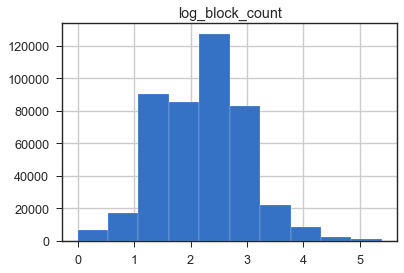

In [140]:
trees.hist('log_block_count', bins=10)

### EDA - Boroughs
* Take a look at the health of trees across the boroughs.

In [142]:
trees.boroname.value_counts()

Queens           164820
Staten Island     95733
Brooklyn          95101
Bronx             68082
Manhattan         20654
Name: boroname, dtype: int64

In [143]:
trees.groupby('boroname').health.value_counts()

boroname       health
Bronx          Good       57183
               Fair        8409
               Poor        2490
Brooklyn       Good       76921
               Fair       14375
               Poor        3805
Manhattan      Good       16084
               Fair        3420
               Poor        1150
Queens         Good      135189
               Fair       23364
               Poor        6267
Staten Island  Good       78214
               Fair       13480
               Poor        4039
Name: health, dtype: int64

In [144]:
trees.groupby('boroname').health.value_counts(normalize=True)

boroname       health
Bronx          Good      0.839914
               Fair      0.123513
               Poor      0.036574
Brooklyn       Good      0.808835
               Fair      0.151155
               Poor      0.040010
Manhattan      Good      0.778735
               Fair      0.165585
               Poor      0.055679
Queens         Good      0.820222
               Fair      0.141755
               Poor      0.038023
Staten Island  Good      0.817001
               Fair      0.140808
               Poor      0.042190
Name: health, dtype: float64

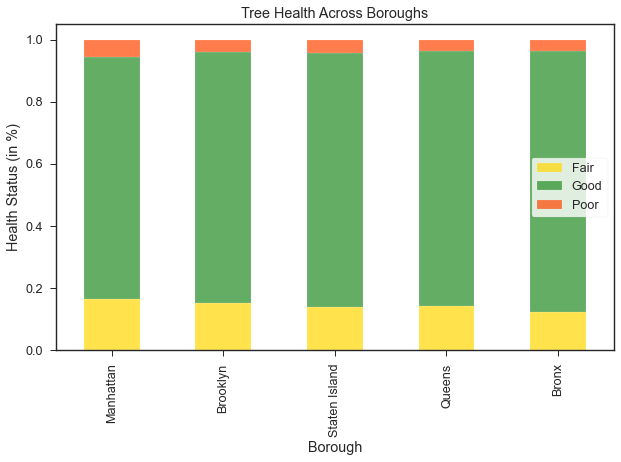

In [167]:
# sort by percentage of trees in good health
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p1 = boros.plot(kind = 'bar', stacked = True, 
                   title = 'Tree Health Across Boroughs', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70, figsize=(10,6))
p1.set_xlabel('Borough')
p1.set_ylabel('Health Status (in %)')
p1.legend(['Fair','Good', 'Poor'])
plt.show()

* There does seem to be a difference between the boroughs, especially Manhattan from the rest.
* Let's do some statistical analyses.

In [169]:
# create a frequency table
df_boro_health = pd.crosstab(trees.health, trees.boroname)
df_boro_health

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,8409,14375,3420,23364,13480
Good,57183,76921,16084,135189,78214
Poor,2490,3805,1150,6267,4039


In [175]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_boro_health)
# p-value shows significance
p

3.530263683508544e-117

In [176]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table = sm.stats.Table(df_boro_health)
table.standardized_resids

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,-14.922137,9.250982,10.000898,-0.177116,-1.068283
Good,15.977694,-8.427983,-15.051476,2.710004,-1.067351
Poor,-4.881134,0.116258,11.825406,-5.021920,4.005638


In [178]:
# percentage of significant values
abs_table = table.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table[abs_table > 1.96].count().sum() / abs_table.count().sum()) * 100, 2)}%')

73.33%


### EDA - Community Boards

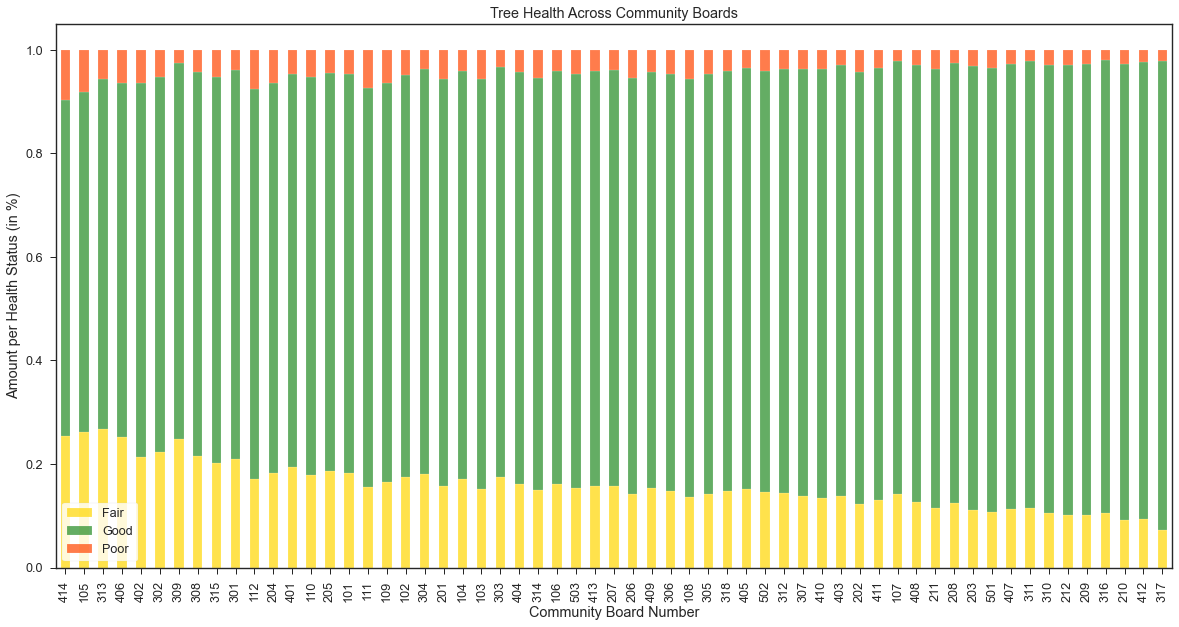

In [180]:
# sort by percentage of trees in good health
community_boards = trees.groupby(['cb_num']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p2 = community_boards.plot(kind = 'bar', stacked = True, figsize=(20,10),
                   title = 'Tree Health Across Community Boards', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
p2.set_xlabel('Community Board Number')
p2.set_ylabel('Amount per Health Status (in %)')
p2.legend(['Fair','Good', 'Poor'])
plt.show()

* There does seem to be a difference between most community board areas.
* Let's do some statistical analyses.

In [181]:
# create a frequency table
df_cb_health = pd.crosstab(trees.health, trees.cb_num)
df_cb_health

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,344,316,232,154,151,198,253,282,296,375,...,1940,1019,1780,2715,2082,4997,2438,2518,3291,7671
Good,1446,1395,1212,710,377,977,1495,1676,1375,1619,...,12952,5343,10898,17499,19767,25522,6231,20231,18306,39677
Poor,89,86,85,36,47,51,40,115,113,111,...,438,278,485,719,541,1314,933,809,910,2320


In [183]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_cb_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(142.13816003902645, 7345.570039622511)

In [184]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table2 = sm.stats.Table(df_cb_health)
table2.standardized_resids

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,5.129318,4.135827,1.106630,2.516209,8.302588,1.972131,-0.045719,-0.763919,2.916401,4.780778,...,-5.534750,2.726784,-2.219009,-5.172068,-21.514019,8.013637,31.807539,-15.816677,1.917722,8.518952
Good,-5.476062,-4.612954,-2.590196,-2.280614,-10.111078,-1.934466,1.971846,-1.146535,-5.205602,-5.849639,...,8.722672,-2.876107,2.943221,6.829744,25.745851,-7.889693,-43.472485,16.600254,-1.929381,-11.854639
Poor,1.646141,1.716374,3.129772,0.008489,5.121022,0.296153,-3.802197,3.619290,5.056362,3.002939,...,-7.318128,0.806150,-1.843072,-4.236120,-12.374838,1.260728,28.947729,-4.513437,0.383085,8.169549


In [186]:
# percentage of significant values
abs_table2 = table2.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table2[abs_table2 > 1.96].count().sum() / abs_table2.count().sum()) * 100, 2)}%')

75.71%


### EDA - Neighborhoods

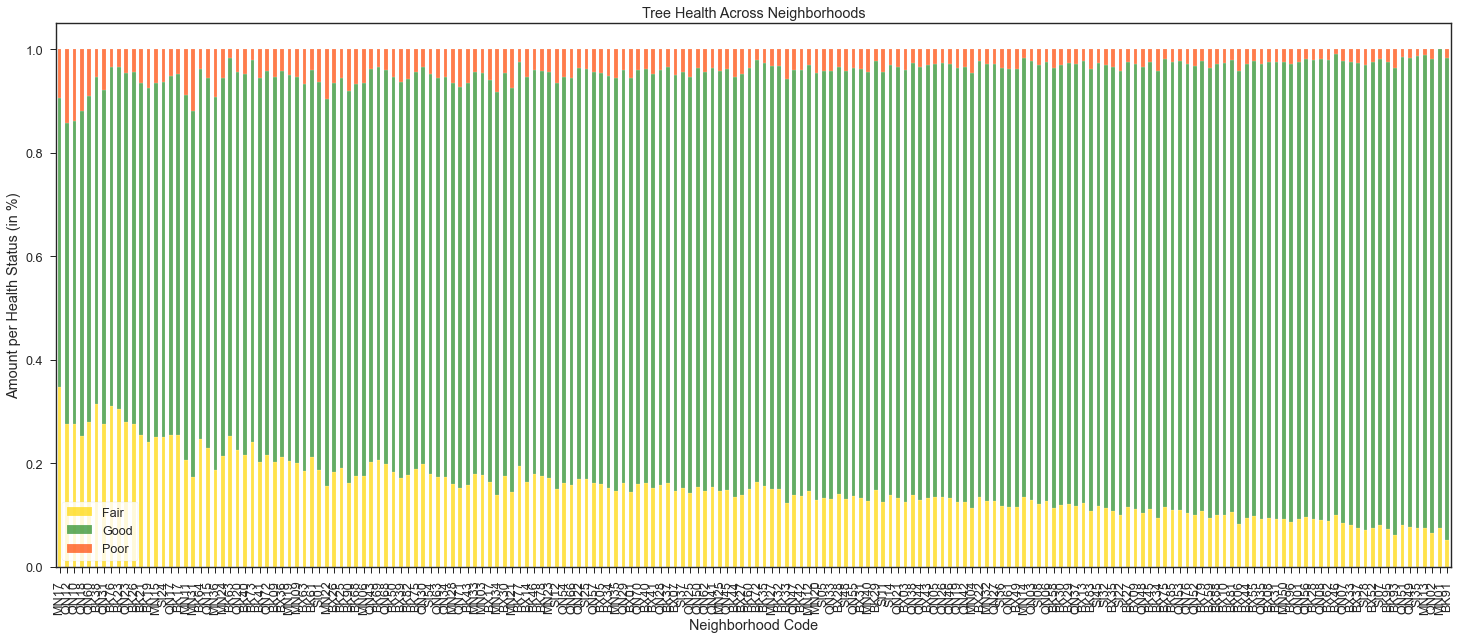

In [187]:
# sort by percentage of trees in good health
neighborhoods = trees.groupby(['nta']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p3 = neighborhoods.plot(kind = 'bar', stacked = True, figsize=(25,10),
                   title = 'Tree Health Across Neighborhoods', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
p3.set_xlabel('Neighborhood Code')
p3.set_ylabel('Amount per Health Status (in %)')
p3.legend(['Fair','Good', 'Poor'])
plt.show()

* There does seem to be a difference between the neighborhoods, though these may be too correlated to community board, since each community board is composed of one or a few neighborhoods.
* Let's do some statistical analyses.

In [188]:
# create a frequency table
df_nta_health = pd.crosstab(trees.health, trees.nta)
df_nta_health

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,30,1132,182,314,136,675,215,151,187,296,...,959,668,214,1008,238,560,521,519,880,1782
Good,110,3082,514,839,295,2672,529,1116,1809,1655,...,2618,3134,2681,7563,2861,4035,2737,3764,5521,7685
Poor,8,215,57,81,15,197,35,32,41,45,...,241,150,92,271,40,175,148,119,275,482


In [191]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_nta_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(420.09408303637986, 12810.553650717877)

In [192]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table3 = sm.stats.Table(df_nta_health)
table3.standardized_resids

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,2.121165,21.797632,7.857331,11.350140,9.874106,8.323038,10.737758,-2.651511,-6.491918,0.824057,...,19.440027,4.914049,-11.037866,-7.587663,-10.644162,-4.870721,1.862093,-4.581456,-2.373582,10.766321
Good,-2.363995,-21.210308,-9.653901,-12.611392,-8.586783,-9.953336,-10.074908,3.831576,8.197327,1.274632,...,-21.315473,-4.119667,11.285759,9.153572,13.594823,4.992886,-2.217250,6.376933,1.881180,-11.963350
Poor,0.876589,2.936571,5.013913,4.615492,-0.681190,4.773887,0.710913,-2.822096,-4.577958,-3.978687,...,7.344349,-0.641763,-2.561007,-4.508978,-7.810264,-1.155269,1.049172,-4.396590,0.524073,4.379370


In [193]:
# percentage of significant values
abs_table3 = table3.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table3[abs_table3 > 1.96].count().sum() / abs_table3.count().sum()) * 100, 2)}%')

68.97%


* Percentage of significant values is lower than that of community boards. Might be an argument for using community boards as a feature instead.

# TEMPORARY SHIT

In [194]:
trees.columns

Index(['tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward', 'guards',
       'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
       'branch_other', 'cb_num', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'log_block_count'],
      dtype='object')

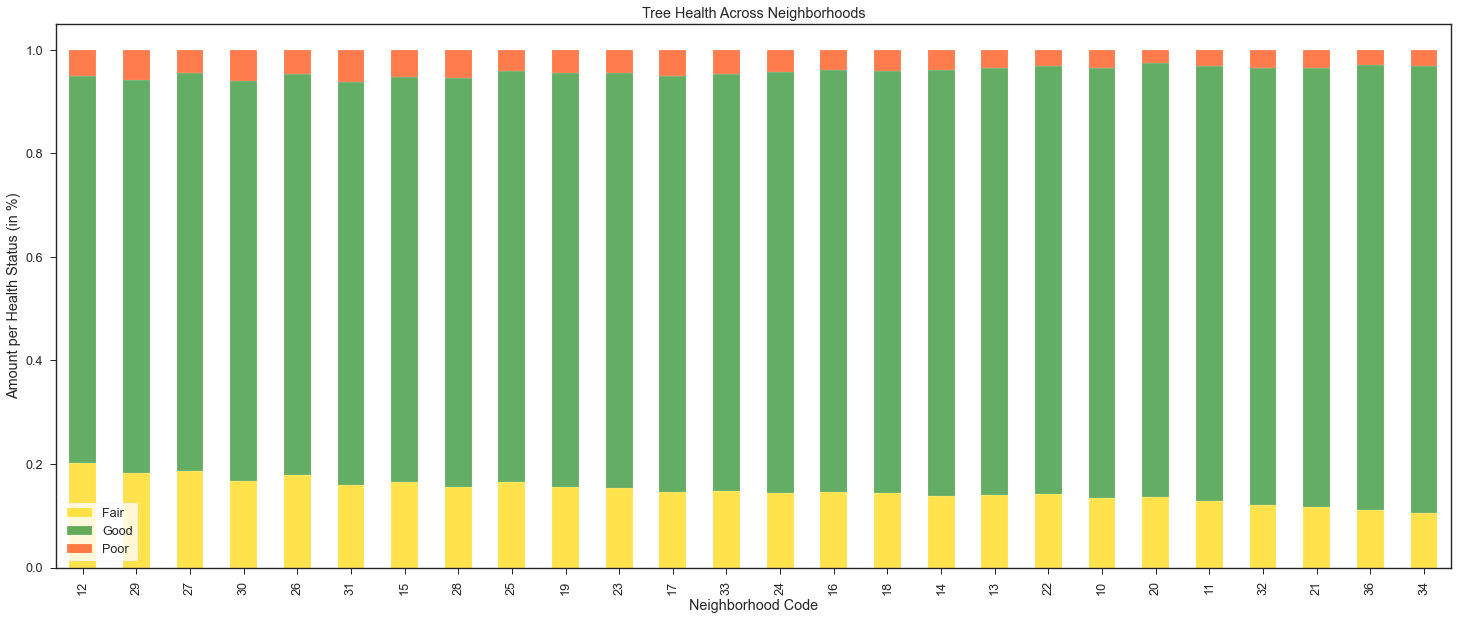

In [203]:
# sort by percentage of trees in good health
council_district = trees.groupby(['st_senate']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p3 = council_district.plot(kind = 'bar', stacked = True, figsize=(25,10),
                   title = 'Tree Health Across Neighborhoods', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
p3.set_xlabel('Neighborhood Code')
p3.set_ylabel('Amount per Health Status (in %)')
p3.legend(['Fair','Good', 'Poor'])
plt.show()

In [204]:
# create a frequency table
df_cd = pd.crosstab(trees.health, trees.st_senate)
df_cd

st_senate,10,11,12,13,14,15,16,17,18,19,...,26,27,28,29,30,31,32,33,34,36
health,,,,,,,,,,,,,,,,,,,,,
Fair,3675,6815,1215,997,4219,4142,2299,1994,1122,3809,...,888,590,482,1358,831,745,1620,1507,2730,1322
Good,22605,44739,4506,5870,25245,19473,12746,10903,6379,19724,...,3857,2426,2433,5673,3821,3657,11258,8208,22610,10218
Poor,957,1610,301,246,1220,1323,610,693,320,1098,...,235,142,170,438,299,289,469,483,806,357


In [205]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table3b = sm.stats.Table(df_cd)
table3b.standardized_resids

st_senate,10,11,12,13,14,15,16,17,18,19,...,26,27,28,29,30,31,32,33,34,36
health,,,,,,,,,,,,,,,,,,,,,
Fair,-3.392222,-9.639641,13.409767,-0.416550,-2.277409,11.281192,1.817599,1.645814,0.405191,5.908649,...,7.411160,7.265615,2.294573,9.977500,5.266404,3.342764,-6.891827,1.727133,-17.894877,-9.745348
Good,5.192473,14.875920,-14.164834,1.558396,2.147120,-15.729262,-1.320817,-4.880626,-0.591148,-7.285157,...,-8.037462,-7.306987,-4.266658,-13.251488,-8.515463,-6.891319,7.696308,-3.527251,20.128851,11.664743
Poor,-4.182700,-12.123317,4.005303,-2.327148,-0.171052,10.879156,-0.637121,6.680195,0.442341,3.820663,...,2.625243,1.445860,4.315015,8.321924,7.388149,7.616792,-2.878653,3.869758,-7.760328,-5.610385


In [206]:
# percentage of significant values
abs_table3b = table3b.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table3b[abs_table3b > 1.96].count().sum() / abs_table3b.count().sum()) * 100, 2)}%')

80.77%


In [208]:
testers = ['cb_num', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta']
for tester in testers:
    df_ = pd.crosstab(trees.health, trees[tester])
    table_ = sm.stats.Table(df_)
    abs_table_ = table_.standardized_resids.apply(lambda x: abs(x))
    print(f'{tester}: {round((abs_table_[abs_table_ > 1.96].count().sum() / abs_table_.count().sum()) * 100, 2)}%')

cb_num: 75.71%
boroname: 73.33%
council_dist: 77.78%
st_assem: 77.95%
st_senate: 80.77%
nta: 68.97%


### EDA - Tree species

In [210]:
print(f'Number of unique species: {len(trees.spc_common.unique())}')
print(f'Number of total trees: {len(trees)}')
print(f'Cutoff for trees of significant quantity (0.1% of total trees): {np.ceil(len(trees)/1000)}')

Number of unique species: 132
Number of total trees: 444390
Cutoff for trees of significant quantity (0.1% of total trees): 445.0


In [211]:
# create a column with the total count of that row's tree species
species_counts = trees['spc_common'].value_counts().rename('species_counts')

# merge onto dataframe
trees = trees.merge(species_counts.to_frame(),
                                left_on='spc_common',
                                right_index=True)

# reassign tree species with fewer than 445 datapoints to 'Other'
trees['spc_common'] = np.where(trees.species_counts < 445, 'Other', trees.spc_common)

trees.spc_common.value_counts().head(20)

London planetree     60350
Callery pear         42487
honeylocust          38349
pin oak              35985
Norway maple         25253
cherry               22772
Japanese zelkova     18928
littleleaf linden    18469
red maple            13906
ginkgo               11355
green ash            10572
Sophora              10440
silver maple         10081
Other                 9918
American linden       8399
sweetgum              8380
purple-leaf plum      5281
maple                 5211
American elm          5192
northern red oak      5153
Name: spc_common, dtype: int64

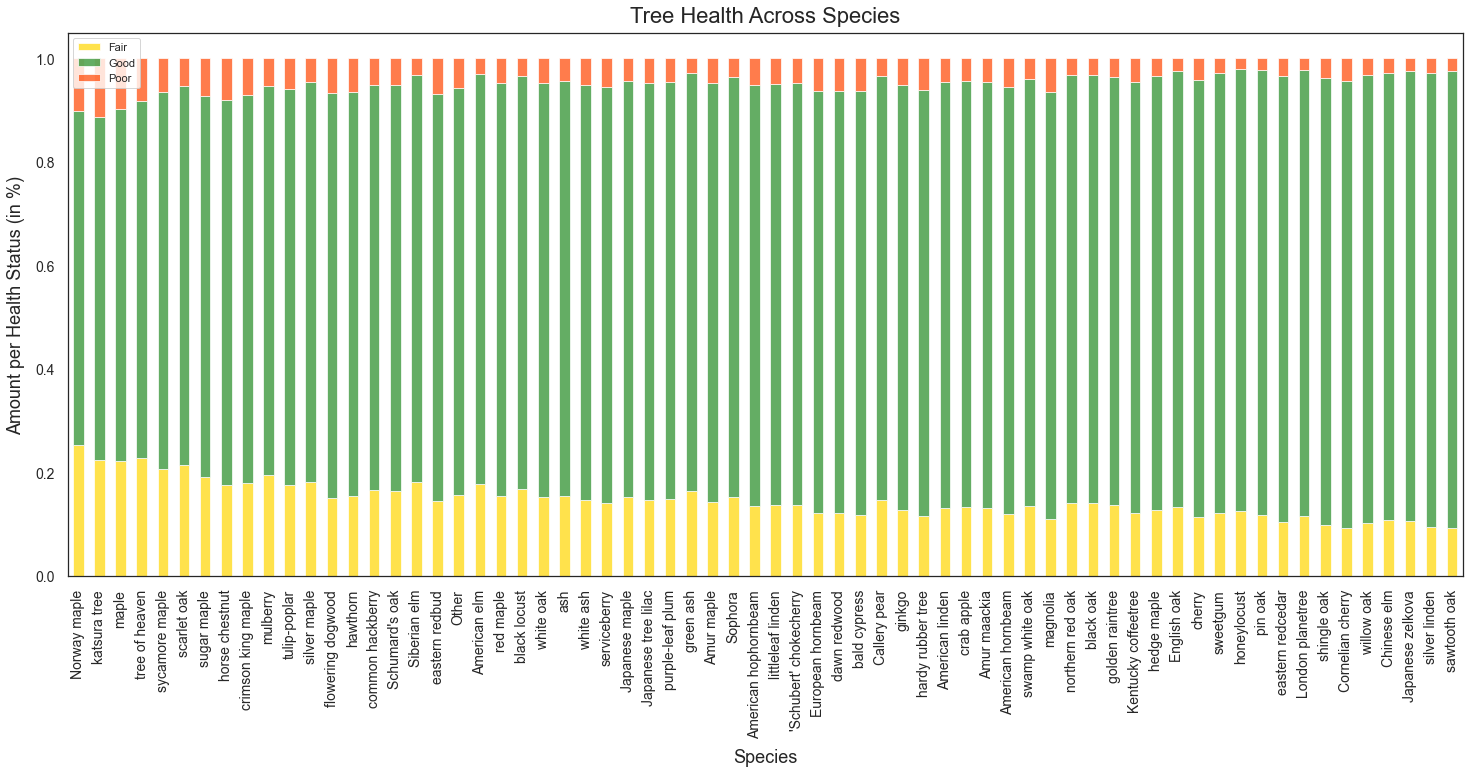

In [218]:
# sort by percentage of trees in good health
spc = trees.groupby(['spc_common']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p4 = spc.plot(kind = 'bar', stacked = True, figsize=(25,10),
#                    title = 'Tree Health Across Species', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70, fontsize=14)
p4.set_title('Tree Health Across Species', fontsize=22, pad=10)
p4.set_xlabel('Species', fontsize=18, labelpad=10)
p4.set_ylabel('Amount per Health Status (in %)', fontsize=18, labelpad=10)
p4.legend(['Fair','Good', 'Poor'])
plt.show()

* There does seem to be a difference between species.
* Let's do some statistical analyses.

In [222]:
# create a frequency table
df_spc_health = pd.crosstab(trees.health, trees.spc_common)
df_spc_health

spc_common,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,442,926,93,140,1099,225,237,6216,304,65,...,1843,350,568,1017,405,106,129,130,175,210
Good,2606,4110,559,954,6913,1412,1342,34820,2444,608,...,7771,1345,3473,7125,1433,321,560,712,916,1761
Poor,151,156,35,63,387,77,79,1451,77,30,...,467,134,167,238,126,38,43,46,54,65


In [224]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_spc_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(157.60992312288903, 10713.620636908676)

In [225]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table4 = sm.stats.Table(df_spc_health)
table4.standardized_resids

spc_common,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,-0.603106,7.576995,-0.488967,-2.037439,-2.923916,-1.260565,0.124858,2.750728,-5.236162,-3.757917,...,11.917738,6.077938,-1.287867,-5.433738,8.189565,5.322743,2.666022,0.386499,1.064549,-5.020267
Good,-0.522527,-4.994458,-0.305859,0.562176,1.174069,0.604845,-0.927706,0.766975,6.490975,3.211830,...,-12.461487,-9.200599,1.208732,7.681683,-10.196686,-7.152113,-3.731584,-1.266663,-1.597022,5.481938
Poor,2.103740,-3.663597,1.473631,2.523008,2.897351,1.054760,1.604699,-6.411759,-3.454697,0.369866,...,3.308921,7.291597,-0.085981,-5.447825,5.491013,4.602577,2.599321,1.806109,1.248642,-1.852017


In [226]:
# percentage of significant values
abs_table4 = table4.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table4[abs_table4 > 1.96].count().sum() / abs_table4.count().sum()) * 100, 2)}%')

62.12%


In [227]:
# drop no longer necessary counts column
trees.drop(columns='species_counts', axis=1, inplace=True)

In [228]:
# uncomment to save
# trees.to_csv('data/nyc_trees_2015_pre_dummies.csv')

### GeoPandas feature engineering

* Let's see if the distance between trees has any bearing on health. To do this, let's use all the datapoints.

In [229]:
trees_for_geo = pd.read_csv('data/nyc_trees_2015_initial_clean.csv', index_col=0)
trees_for_geo.head()

,block_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,root_stone,...,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,nta_name,latitude,longitude
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,348711,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,...,No,406,Queens,29,28,16,QN17,Forest Hills,40.723092,-73.844215
200540,315986,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,...,No,407,Queens,19,27,11,QN49,Whitestone,40.794111,-73.818679
204026,218365,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,...,No,301,Brooklyn,34,50,18,BK90,East Williamsburg,40.717581,-73.936608
204337,217969,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,...,No,301,Brooklyn,34,53,18,BK90,East Williamsburg,40.713537,-73.934456
189565,223043,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,...,No,306,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,40.666778,-73.975979


In [95]:
# create geodataframe
trees_gdf = gpd.GeoDataFrame(trees_for_geo[['health', 'latitude', 'longitude']],
                             geometry=gpd.points_from_xy(trees_for_geo.longitude, trees_for_geo.latitude))
# reset index to sequential numbers
trees_gdf.reset_index(inplace=True)
trees_gdf.head()

,tree_id,health,latitude,longitude,geometry
0,180683,Fair,40.723092,-73.844215,POINT (-73.84422 40.72309)
1,200540,Fair,40.794111,-73.818679,POINT (-73.81868 40.79411)
2,204026,Good,40.717581,-73.936608,POINT (-73.93661 40.71758)
3,204337,Good,40.713537,-73.934456,POINT (-73.93446 40.71354)
4,189565,Good,40.666778,-73.975979,POINT (-73.97598 40.66678)


In [96]:
# Find closest tree and return a dataframe with a new distance column
closest_trees = nearest_neighbor(trees_gdf, return_dist=True)

closest_trees.head()

,tree_id,health,latitude,longitude,geometry,distance
0,236470,Good,40.723001,-73.844173,POINT (-73.84417 40.72300),5.507949
1,200541,Good,40.794090,-73.818770,POINT (-73.81877 40.79409),10.087328
2,204025,Good,40.717634,-73.936631,POINT (-73.93663 40.71763),3.098257
3,204336,Good,40.713563,-73.934360,POINT (-73.93436 40.71356),10.693152
4,218654,Good,40.666648,-73.975948,POINT (-73.97595 40.66665),5.258800


* See if distance from the nearest tree has any impact.

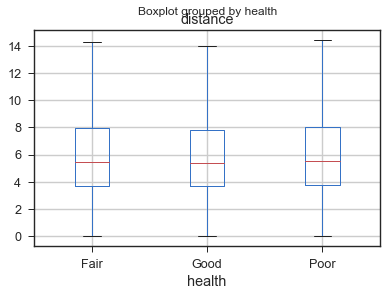

In [97]:
closest_trees.boxplot('distance', 'health', showfliers=False)

* Alas, the quartiles and medians are almost identical; there are no distinct differences here.

### Dummy columns

* We have a lot of categorical variables that we need to make dummies for.
* We also have to decide which area variable to use: community board? council district? state assembly? state senate? neighborhood?

In [1]:
trees = pd.read_csv('data/nyc_trees_2015_pre_dummies.csv', index_col=0)

In [2]:
trees.columns

Index(['tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward', 'guards',
       'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
       'branch_other', 'cb_num', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'log_block_count'],
      dtype='object')

In [3]:
trees.curb_loc.unique()

array(['OnCurb', 'OffsetFromCurb'], dtype=object)

In [4]:
trees.sidewalk.unique()

array(['NoDamage', 'Damage'], dtype=object)

In [5]:
# rename columns that we have to manually dummy, so the new 0 and 1 values make sense
trees.rename(columns={'curb_loc': 'on_curb', 'sidewalk': 'sidewalk_damage'}, inplace=True)

# trees on curb = 1; trees offset from curb = 0
trees.on_curb = np.where(trees.on_curb == 'OnCurb', 1, 0)
# damage to sidewalk near tree = 1; no sidewalk damage = 0
trees.sidewalk_damage = np.where(trees.sidewalk_damage == 'Damage', 1, 0)

* Reassign yes-no columns to 1s and 0s.

In [6]:
trees.branch_other.unique()

array(['No', 'Yes'], dtype=object)

In [11]:
# create list of columns to dummy
yes_no_cols = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
               'branch_light', 'branch_shoe', 'branch_other']

# call custom function
yes_to_one(trees, yes_no_cols)
# check to make sure it worked
trees.branch_other.unique()

array([0, 1])

In [12]:
yes_no_cols.extend(['on_curb', 'sidewalk_damage'])

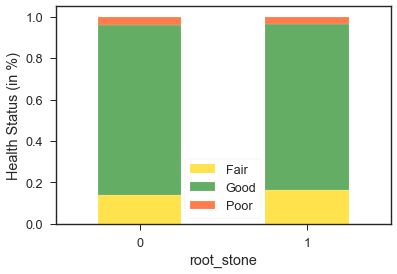

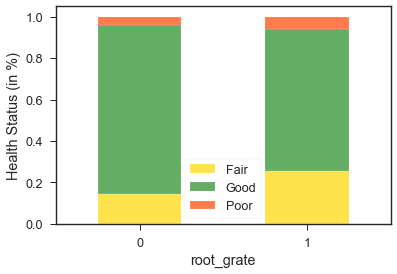

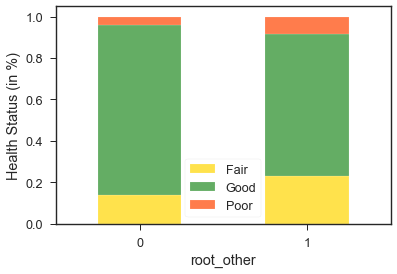

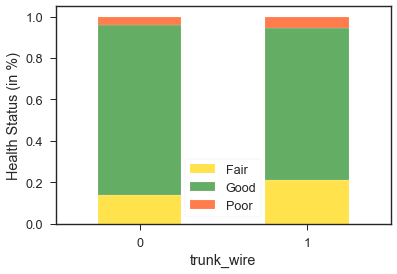

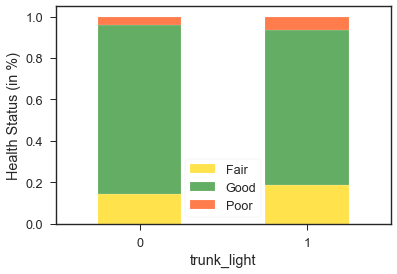

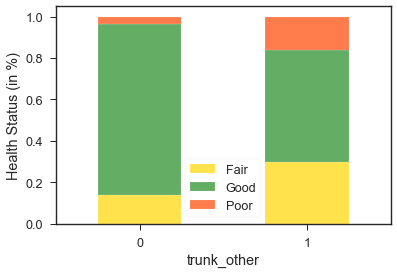

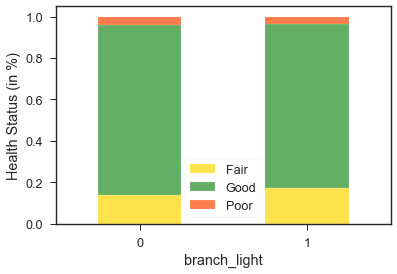

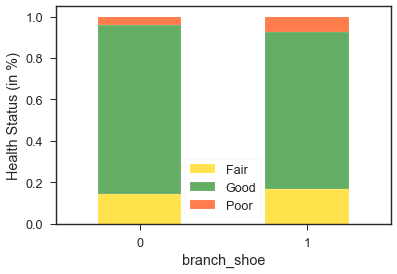

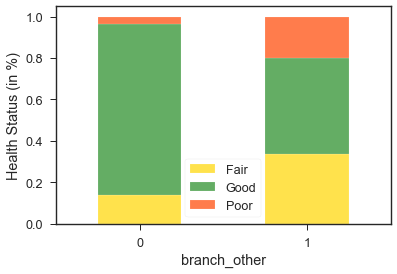

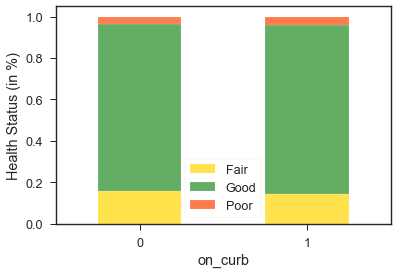

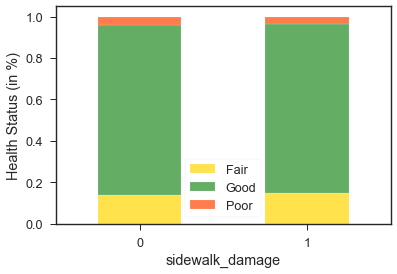

In [13]:
# for loop of what we were doing before, so we can take a look at all these binary variables
for col in yes_no_cols:
    grouped = trees.groupby(col).health.value_counts(normalize=True).unstack()
    ax = grouped.plot(kind = 'bar', stacked = True, 
#                        title = f'', 
                       color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
    ax.set_xticklabels([0,1], rotation=0)
    ax.set_xlabel(col)
    ax.set_ylabel('Health Status (in %)')
    ax.legend(['Fair','Good', 'Poor'])

* Lots of signficant looking variables here. Some that don't quite meet the mark are: root_stone, branch_light, on_curb, and sidewalk_damage.

* Dummy variables with more than two values:
    * First rename a steward value that doesn't make sense (4 is accounted for twice, so renaming '4orMore' to '5plus').
    * Create dummies for number of stewards, usefulness of tree guards, and borough name.

In [14]:
trees['steward'] = np.where(trees.steward == '4orMore', '5plus', trees.steward)

In [15]:
trees.steward.unique()

array(['None', '1or2', '3or4', '5plus'], dtype=object)

In [16]:
trees.groupby('steward').health.value_counts(normalize=True)

steward  health
1or2     Good      0.811771
         Fair      0.146373
         Poor      0.041856
3or4     Good      0.828384
         Fair      0.133413
         Poor      0.038203
5plus    Good      0.833811
         Fair      0.133238
         Poor      0.032951
None     Good      0.819346
         Fair      0.141077
         Poor      0.039577
Name: health, dtype: float64

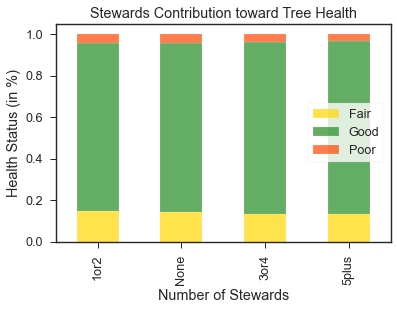

In [17]:
# sort by percentage of trees in good health
stewards = trees.groupby(['steward']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p5 = stewards.plot(kind = 'bar', stacked = True, 
                   title = 'Stewards Contribution toward Tree Health', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
p5.set_xlabel('Number of Stewards')
p5.set_ylabel('Health Status (in %)')
p5.legend(['Fair','Good', 'Poor'])
plt.show()

* Health status looks similar across all values.

In [18]:
trees.guards.value_counts()

None       413018
Helpful     21896
Harmful      6222
Unsure       3254
Name: guards, dtype: int64

In [19]:
trees.groupby('guards').health.value_counts(normalize=True)

guards   health
Harmful  Good      0.763581
         Fair      0.183864
         Poor      0.052555
Helpful  Good      0.831339
         Fair      0.129156
         Poor      0.039505
None     Good      0.818657
         Fair      0.141691
         Poor      0.039652
Unsure   Good      0.773510
         Fair      0.170559
         Poor      0.055931
Name: health, dtype: float64

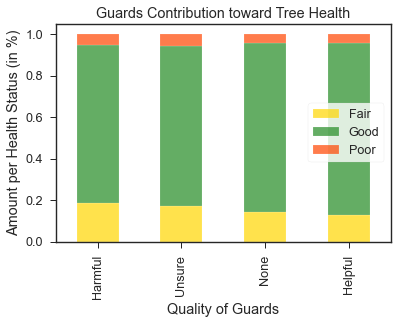

In [20]:
# sort by percentage of trees in good health
guards = trees.groupby(['guards']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p6 = guards.plot(kind = 'bar', stacked = True, 
                   title = 'Guards Contribution toward Tree Health', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
p6.set_xlabel('Quality of Guards')
p6.set_ylabel('Amount per Health Status (in %)')
p6.legend(['Fair','Good', 'Poor'])
plt.show()

* Health status looks affected by the quality of the tree guards.

In [21]:
# sort by percentage of trees in good health
# plot a stacked bar graph
* There does seem to be a difference between the boroughs, especially Manhattan from the rest.
* Let's do some statistical analyses.
# create a frequency table
# p-value shows significance
# create a table of standardized residuals; anything over +/-1.96 shows significance
# percentage of significant values
print(f'{round((
    ) * 100, 2)}%')

SyntaxError: invalid syntax (<ipython-input-21-810d5f1f70e0>, line 3)

In [22]:
trees.columns

Index(['tree_dbh', 'on_curb', 'health', 'spc_common', 'steward', 'guards',
       'sidewalk_damage', 'root_stone', 'root_grate', 'root_other',
       'trunk_wire', 'trunk_light', 'trunk_other', 'branch_light',
       'branch_shoe', 'branch_other', 'cb_num', 'boroname', 'council_dist',
       'st_assem', 'st_senate', 'nta', 'log_block_count'],
      dtype='object')

In [23]:
dummy_cols = ['steward', 'guards', 'boroname', 'cb_num', 'spc_common',
              'council_dist', 'st_assem', 'st_senate', 'nta',
             ]

# convert some columns to string so we can easily dummy it
trees['cb_num'] = trees.cb_num.astype(str)
trees['council_dist'] = trees.council_dist.astype(str)
trees['st_assem'] = trees.st_assem.astype(str)
trees['st_senate'] = trees.st_senate.astype(str)

In [24]:
tree_dummies = pd.get_dummies(trees[dummy_cols])
tree_dummies.columns = [col.replace(' ', '_').replace("'", "") for col in list(tree_dummies.columns)]
tree_dummies.columns

Index(['steward_1or2', 'steward_3or4', 'steward_5plus', 'steward_None',
       'guards_Harmful', 'guards_Helpful', 'guards_None', 'guards_Unsure',
       'boroname_Bronx', 'boroname_Brooklyn',
       ...
       'nta_SI24', 'nta_SI25', 'nta_SI28', 'nta_SI32', 'nta_SI35', 'nta_SI36',
       'nta_SI37', 'nta_SI45', 'nta_SI48', 'nta_SI54'],
      dtype='object', length=468)

In [25]:
dummy_cols.extend(['steward_None', 'guards_None', 'boroname_Staten_Island', 'cb_num_101', 'spc_common_Other',
                  'council_dist_1', 'st_assem_28', 'st_senate_10', 'nta_QN17'])
dummy_cols

['steward',
 'guards',
 'boroname',
 'cb_num',
 'spc_common',
 'council_dist',
 'st_assem',
 'st_senate',
 'nta',
 'steward_None',
 'guards_None',
 'boroname_Staten_Island',
 'cb_num_101',
 'spc_common_Other',
 'council_dist_1',
 'st_assem_28',
 'st_senate_10',
 'nta_QN17']

In [26]:
trees_full = pd.concat([trees,tree_dummies], axis=1)
trees_full.drop(columns=dummy_cols, axis=1, inplace=True)

In [27]:
trees_full.columns

Index(['tree_dbh', 'on_curb', 'health', 'sidewalk_damage', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       ...
       'nta_SI24', 'nta_SI25', 'nta_SI28', 'nta_SI32', 'nta_SI35', 'nta_SI36',
       'nta_SI37', 'nta_SI45', 'nta_SI48', 'nta_SI54'],
      dtype='object', length=473)

In [28]:
trees_full.head()

,tree_dbh,on_curb,health,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,...,nta_SI24,nta_SI25,nta_SI28,nta_SI32,nta_SI35,nta_SI36,nta_SI37,nta_SI45,nta_SI48,nta_SI54
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3.0,1,Fair,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180672,21.0,1,Fair,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200556,10.0,1,Fair,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205047,10.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192941,9.0,1,Good,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
conditions = [
    trees.health == 'Good',
    trees.health == 'Fair'
]

choices = [
    2,
    1
]

trees_full['health_num'] = np.select(conditions, choices, 0)

In [30]:
X = trees_full.drop(columns=['health', 'health_num'], axis=1)
y = trees_full['health_num']

In [31]:
X.head()

,tree_dbh,on_curb,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,branch_light,...,nta_SI24,nta_SI25,nta_SI28,nta_SI32,nta_SI35,nta_SI36,nta_SI37,nta_SI45,nta_SI48,nta_SI54
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180672,21.0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200556,10.0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205047,10.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192941,9.0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [36]:
X_sm = sm.add_constant(X)
est = sm.OLS(y, X_sm)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             health_num   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     91.80
Date:                Wed, 27 May 2020   Prob (F-statistic):               0.00
Time:                        20:02:36   Log-Likelihood:            -3.0457e+05
No. Observations:              444390   AIC:                         6.101e+05
Df Residuals:                  443930   BIC:                         6.151e+05
Df Model:                         459                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [37]:
p = est2.pvalues
high_p = p[p > .05].keys()

X_simp = X.drop(columns=high_p)

X_simp.head()

,tree_dbh,on_curb,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_other,branch_light,branch_other,...,nta_QN33,nta_QN34,nta_QN35,nta_QN38,nta_QN43,nta_QN44,nta_QN60,nta_QN61,nta_QN66,nta_QN76
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180672,21.0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200556,10.0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205047,10.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192941,9.0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [38]:
X_sm2 = sm.add_constant(X_simp)
est = sm.OLS(y, X_sm2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             health_num   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     154.6
Date:                Wed, 27 May 2020   Prob (F-statistic):               0.00
Time:                        20:02:55   Log-Likelihood:            -3.0633e+05
No. Observations:              444390   AIC:                         6.132e+05
Df Residuals:                  444141   BIC:                         6.159e+05
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [39]:
p2 = est2.pvalues
high_p2 = p2[p2 > .05].keys()

X_simp2 = X_simp.drop(columns=high_p2)

X_sm3 = sm.add_constant(X_simp2)
est = sm.OLS(y, X_sm3)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             health_num   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     166.5
Date:                Wed, 27 May 2020   Prob (F-statistic):               0.00
Time:                        20:03:08   Log-Likelihood:            -3.0635e+05
No. Observations:              444390   AIC:                         6.132e+05
Df Residuals:                  444159   BIC:                         6.157e+05
Df Model:                         230                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [40]:
p3 = est2.pvalues
high_p3 = p3[p3 > .05].keys()

X_simp3 = X_simp2.drop(columns=high_p3)

X_sm4 = sm.add_constant(X_simp3)
est = sm.OLS(y, X_sm4)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             health_num   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     169.3
Date:                Wed, 27 May 2020   Prob (F-statistic):               0.00
Time:                        20:03:20   Log-Likelihood:            -3.0636e+05
No. Observations:              444390   AIC:                         6.132e+05
Df Residuals:                  444163   BIC:                         6.157e+05
Df Model:                         226                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [41]:
corr_matrix = X_simp3.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

sol[sol > .8]

cb_num_503       council_dist_51    0.943253
                 st_assem_62        0.878996
council_dist_51  st_assem_62        0.875030
cb_num_212       st_assem_83        0.871433
cb_num_318       council_dist_46    0.864544
council_dist_46  st_assem_59        0.859118
cb_num_318       st_assem_59        0.836287
council_dist_44  st_assem_48        0.832677
cb_num_102       nta_MN23           0.819352
council_dist_9   st_senate_30       0.810979
dtype: float64

In [42]:
X_simp3.drop(columns=['cb_num_503', 'council_dist_51', 'cb_num_212', 'cb_num_318', 'council_dist_46', 
                     'council_dist_44', 'cb_num_102', 'council_dist_9', 'st_assem_62'], inplace=True)

In [43]:
corr_matrix = X_simp3.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

sol[sol > .8]

Series([], dtype: float64)

## SAVE A COPY

In [44]:
trees_full.to_csv('data/nyc_trees_2015_new.csv')

In [45]:
trees_full = pd.read_csv('data/nyc_trees_2015_new.csv', index_col=0)
trees_full.head()

,tree_dbh,on_curb,health,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,...,nta_SI25,nta_SI28,nta_SI32,nta_SI35,nta_SI36,nta_SI37,nta_SI45,nta_SI48,nta_SI54,health_num
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3.0,1,Fair,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
180672,21.0,1,Fair,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
200556,10.0,1,Fair,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
205047,10.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
192941,9.0,1,Good,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
please break this code

## Vanilla models

In [369]:
X_van = X_simp3.copy()
y_van = trees_full['health']

In [169]:
X_train_van, X_test_van, y_train_van, y_test_van = train_test_split(X_van, y_van, random_state=42, stratify=y_van)

### Resample

In [170]:
# concatenate our training data back together
training  = pd.concat([X_train_van, y_train_van], axis=1)

In [171]:
# separate minority and majority classes
good = training[training.health=='Good']
fair = training[training.health=='Fair']
poor = training[training.health=='Poor']

In [172]:
# Get a class count to understand the class imbalance.
print('good count: '+ str(len(good)))
print('fair count: '+ str(len(fair)))
print('poor count: '+ str(len(poor)))

good count: 272693
fair count: 47286
poor count: 13313


In [173]:
# downsample majority
good_downsampled = resample(good,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

# downsample majority
fair_downsampled = resample(fair,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

In [174]:
# combine minority and downsampled majority
downsampled = pd.concat([good_downsampled, fair_downsampled, poor])

# checking counts
downsampled.health.value_counts()

Good    13313
Fair    13313
Poor    13313
Name: health, dtype: int64

In [175]:
# trying logistic regression again with the balanced dataset
y_train_down = downsampled.health
X_train_down = downsampled.drop('health', axis=1)


# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_lr = LogisticRegression(class_weight='balanced', multi_class='multinomial', random_state=42, n_jobs=-1)


# downsampled_dt.fit(X_train, y_train)
downsampled_lr.fit(X_train_down, y_train_down)

# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred = downsampled_lr.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, downsampled_pred))

# checking f1
print('Test F1 score: ', f1_score(y_test_van, downsampled_pred, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van, downsampled_pred, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van, downsampled_pred, average='weighted'))

Test Accuracy score:  0.5456983924103044
Test F1 score:  0.6185737140646788
Test Recall score:  0.5456983924103044
Test Precision score:  0.747739638364124


In [176]:
# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_forest = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)


# downsampled_dt.fit(X_train, y_train)
downsampled_forest.fit(X_train_down, y_train_down)

# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred_forest = downsampled_forest.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, downsampled_pred_forest))

# checking f1
print('Test F1 score: ', f1_score(y_test_van, downsampled_pred_forest, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van, downsampled_pred_forest, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van, downsampled_pred_forest, average='weighted'))

Test Accuracy score:  0.4731318295558876
Test F1 score:  0.5549283766743528
Test Recall score:  0.4731318295558876
Test Precision score:  0.7555963095878665


In [177]:
ant_forest = RandomForestClassifier(criterion = 'entropy', max_depth = 8, n_estimators = 250, 
                             min_samples_leaf = 8, min_samples_split = 2, random_state = 23, 
                             class_weight='balanced', bootstrap=True, n_jobs=-1)

ant_forest.fit(X_train_down, y_train_down)

#Predict the response for test dataset
y_pred_forest_van = ant_forest.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_forest_van))

# checking f1
print('Test F1 score: ', f1_score(y_test_van, y_pred_forest_van, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van, y_pred_forest_van, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van, y_pred_forest_van, average='weighted'))

Test Accuracy score:  0.5780662118129939
Test F1 score:  0.6412392465286704
Test Recall score:  0.5780662118129939
Test Precision score:  0.7456297682460449


In [178]:
ant_forest = RandomForestClassifier(criterion = 'entropy', max_depth = 8, n_estimators = 250, 
                             min_samples_leaf = 8, min_samples_split = 2, random_state = 23, 
                             class_weight='balanced', bootstrap=True, n_jobs=-1)

ant_forest.fit(X_train_van, y_train_van)

#Predict the response for test dataset
y_pred_forest_van = ant_forest.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_forest_van))

# checking f1
print('Test F1 score: ', f1_score(y_test_van, y_pred_forest_van, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van, y_pred_forest_van, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van, y_pred_forest_van, average='weighted'))

Test Accuracy score:  0.6026571135393977
Test F1 score:  0.6572653221291723
Test Recall score:  0.6026571135393977
Test Precision score:  0.7455087800499963


In [179]:
X_van_fewer = X_simp.copy()
y_van_fewer = trees_full['health']

In [181]:
X_train_van_fewer, X_test_van_fewer, y_train_van_fewer, y_test_van_fewer = train_test_split(
                                                                            X_van_fewer, y_van_fewer,
                                                                            random_state=42, stratify=y_van_fewer)

In [209]:
ant_forest_fewer = RandomForestClassifier(criterion = 'gini', max_depth = 8, n_estimators = 100, 
                             min_samples_leaf = 6, min_samples_split = 2, random_state = 42, 
                             class_weight='balanced', bootstrap=True, n_jobs=-1)

ant_forest_fewer.fit(X_train_van_fewer, y_train_van_fewer)

#Predict the response for test dataset
y_pred_forest_van_fewer = ant_forest_fewer.predict(X_test_van_fewer)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van_fewer, y_pred_forest_van_fewer))

# checking f1
print('Test F1 score: ', f1_score(y_test_van_fewer, y_pred_forest_van_fewer, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van_fewer, y_pred_forest_van_fewer, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van_fewer, y_pred_forest_van_fewer, average='weighted'))

Test Accuracy score:  0.6231615330609012
Test F1 score:  0.6677490516969682
Test Recall score:  0.6231615330609012
Test Precision score:  0.7426988033102823


In [210]:
#create a dictionary of all the parameters you want to tune
params_forest = {
    'max_depth': range(5,16),
#     'max_features': range(12,19),
#     'min_samples_split': range(1,10),
    'min_samples_leaf': range(5,16),
}

In [212]:
#create a grid search object and fit it to the data
forest = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=2)
CV_forest = GridSearchCV(forest, params_forest, scoring='accuracy', n_jobs=-1, verbose=2)
CV_forest.fit(X_train_van_fewer, y_train_van_fewer)

Fitting 5 folds for each of 121 candidates, totalling 605 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 605 out of 605 | elapsed: 59.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100building tree 6 of 100building tree 7 of 100





building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100building tree 27 of 100

building tree 28 of 100
building tree 29 of 100
building tree 30 of 100building tree 31 of 100

building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100building tree 43 of 100
building tree 44 of 100building tree 45 of 100


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100building tree 63 of 100building tree 64 of 100


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                           

In [213]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(CV_forest.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(CV_forest.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(CV_forest.best_estimator_)

0.6519718998084731
{'max_depth': 5, 'min_samples_leaf': 9}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=2,
                       warm_start=False)


In [185]:
#Predict the response for test dataset
y_pred_forest = CV_forest.best_estimator_.predict(X_test_van_fewer)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van_fewer, y_pred_forest))

# checking f1
print('Test F1 score: ', f1_score(y_test_van_fewer, y_pred_forest, average='micro'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van_fewer, y_pred_forest, average='micro'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van_fewer, y_pred_forest, average='micro'))

NameError: name 'CV_forest' is not defined

In [218]:
with open('data/best_model_0526.pickle', 'wb') as f:
    pickle.dump(CV_forest.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [215]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_van_fewer, y_pred_forest)
classes = ['Fair', 'Good', 'Poor']

In [216]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[ 1181  9622  4959]
 [ 3708 70813 16377]
 [  255  2147  2036]]


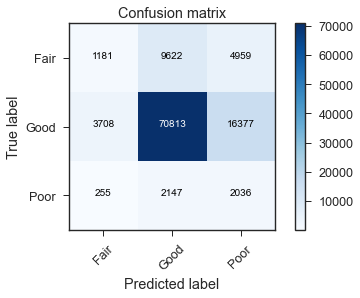

In [217]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Models

In [46]:
X = X_simp3.copy()
y = trees_full['health']

In [47]:
y.head()

tree_id
180683    Fair
180672    Fair
200556    Fair
205047    Good
192941    Good
Name: health, dtype: object

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Resample

In [79]:
# concatenate our training data back together
training  = pd.concat([X_train, y_train], axis=1)

In [80]:
# separate minority and majority classes
good = training[training.health=='Good']
fair = training[training.health=='Fair']
poor = training[training.health=='Poor']

In [81]:
# Get a class count to understand the class imbalance.
print('good count: '+ str(len(good)))
print('fair count: '+ str(len(fair)))
print('poor count: '+ str(len(poor)))

good count: 272693
fair count: 47286
poor count: 13313


In [82]:
# downsample majority
good_downsampled = resample(good,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

# downsample majority
fair_downsampled = resample(fair,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

In [83]:
# combine minority and downsampled majority
downsampled = pd.concat([good_downsampled, fair_downsampled, poor])

# checking counts
downsampled.health.value_counts()

Poor    13313
Fair    13313
Good    13313
Name: health, dtype: int64

In [84]:
# trying logistic regression again with the balanced dataset
y_train_down = downsampled.health
X_train_down = downsampled.drop('health', axis=1)


# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_lr = LogisticRegression(class_weight='balanced', multi_class='multinomial', random_state=42, n_jobs=-1)


# downsampled_dt.fit(X_train, y_train)
downsampled_lr.fit(X_train_down, y_train_down)

# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred = downsampled_lr.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, downsampled_pred))

# checking f1
print('Test F1 score: ', f1_score(y_test, downsampled_pred, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, downsampled_pred, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, downsampled_pred, average='weighted'))

Test Accuracy score:  0.5577868188446237
Test F1 score:  0.6274360114285317
Test Recall score:  0.5577868188446237
Test Precision score:  0.7502734015496769


In [413]:
# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_forest = RandomForestClassifier(class_weight='balanced', random_state=99, n_jobs=-1)


# downsampled_dt.fit(X_train, y_train)
downsampled_forest.fit(X_train_down, y_train_down)

# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred_forest = downsampled_forest.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, downsampled_pred_forest))

# checking f1
print('Test F1 score: ', f1_score(y_test, downsampled_pred_forest, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, downsampled_pred_forest, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, downsampled_pred_forest, average='weighted'))

Test Accuracy score:  0.5261750886604619
Test F1 score:  0.6016082635774749
Test Recall score:  0.5261750886604619
Test Precision score:  0.7703079180955916


In [408]:
ant_forest = RandomForestClassifier(criterion = 'entropy', max_depth = 8, n_estimators = 250, 
                             min_samples_leaf = 8, min_samples_split = 2, random_state = 99, 
                             class_weight='balanced', bootstrap=True, n_jobs=-1)

ant_forest.fit(X_train_down, y_train_down)

#Predict the response for test dataset
y_pred_forest_down = ant_forest.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_down))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_down, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_down, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_down, average='weighted'))

Test Accuracy score:  0.6012259446614701
Test F1 score:  0.6558537676014299
Test Recall score:  0.6012259446614701
Test Precision score:  0.7429408985935103


In [187]:
ant_forest = RandomForestClassifier(criterion = 'entropy', max_depth = 3, n_estimators = 100, 
                             min_samples_leaf = 7, min_samples_split = 2, random_state = 99, 
                             class_weight='balanced', bootstrap=True, n_jobs=-1)

ant_forest.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_forest = ant_forest.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest, average='weighted'))

Test Accuracy score:  0.6879241750526562
Test F1 score:  0.3792063158707042
Test Recall score:  0.43374316680344926
Test Precision score:  0.38723670168570384


In [188]:
#create a dictionary of all the parameters you want to tune
params_forest = {
    'max_depth': range(3,11),
#     'max_features': range(12,19),
#     'min_samples_split': range(1,10),
    'min_samples_leaf': range(5,14),
}

In [189]:
#create a grid search object and fit it to the data
forest = RandomForestClassifier(criterion='entropy', random_state=99, class_weight='balanced', n_jobs=-1)
CV_forest = GridSearchCV(forest, params_forest, scoring='f1_weighted', n_jobs=-1, verbose=2)
CV_forest.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 26.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=Fa

In [190]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(CV_forest.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(CV_forest.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(CV_forest.best_estimator_)

0.7080387409869452
{'max_depth': 3, 'min_samples_leaf': 5}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=99, verbose=0,
                       warm_start=False)


In [191]:
#Predict the response for test dataset
y_pred_forest = CV_forest.best_estimator_.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest, average='weighted'))

Test Accuracy score:  0.6879421771769069
Test F1 score:  0.7047860743774924
Test Recall score:  0.6879421771769069
Test Precision score:  0.7328415898796722


In [171]:
ant_forest = RandomForestClassifier(criterion = 'entropy', max_depth = 3, n_estimators = 100, 
                             min_samples_leaf = 7, min_samples_split = 2, random_state = 99, 
                             class_weight='balanced', bootstrap=True, n_jobs=-1)

ant_forest.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_forest = ant_forest.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest, average='weighted'))

Test Accuracy score:  0.6879241750526562
Test F1 score:  0.7047765601918609
Test Recall score:  0.6879241750526562
Test Precision score:  0.7328375766796354


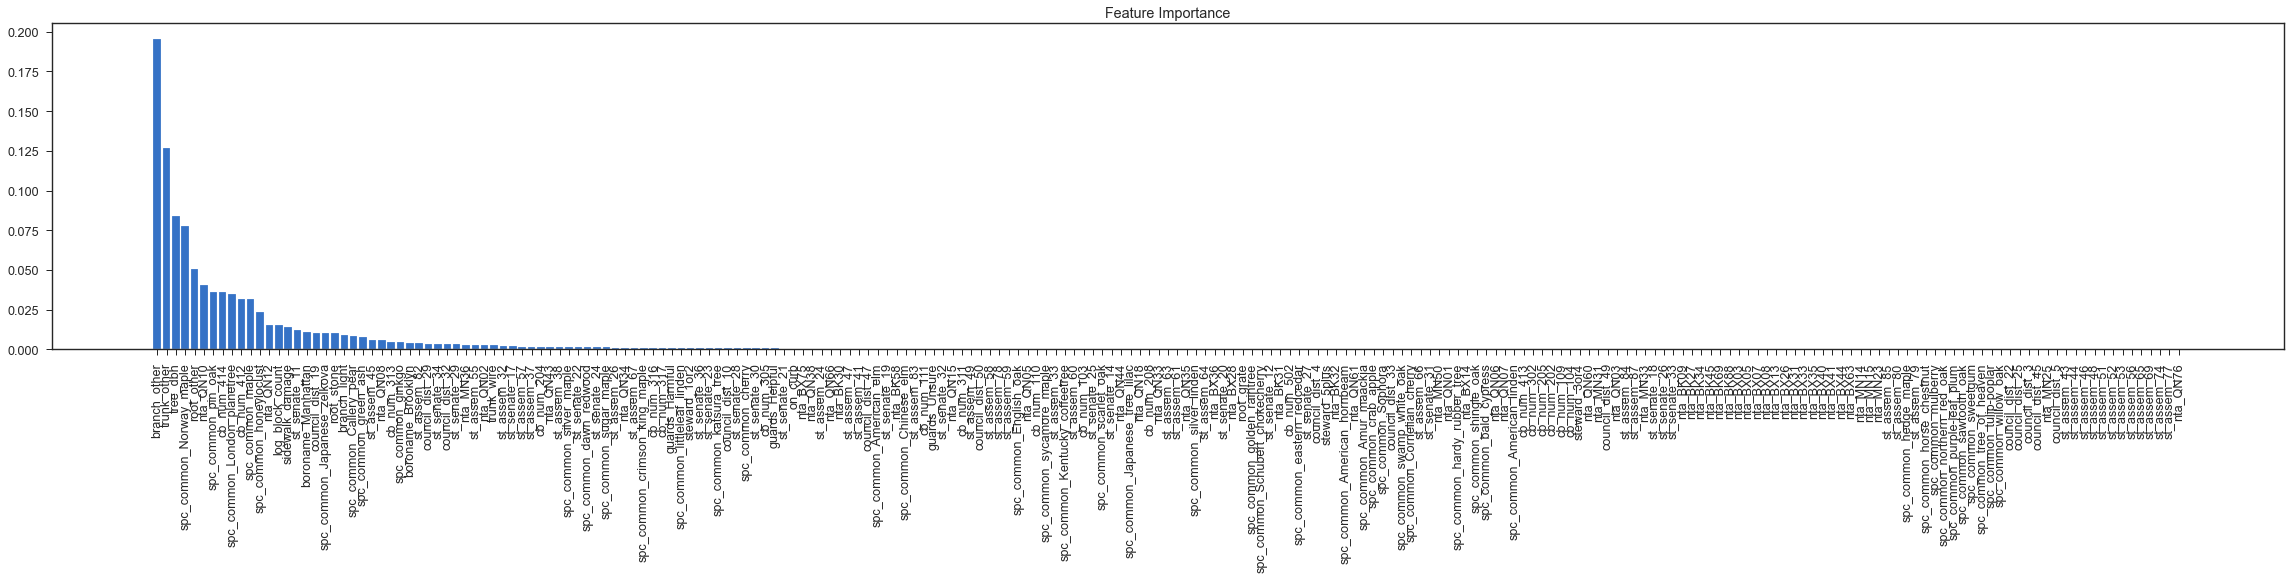

In [175]:
imp_forest = ant_forest.feature_importances_
# Sort feature importances in descending order
indices_forest = np.argsort(imp_forest)[::-1]

# Rearrange feature names so they match the sorted feature importances
names_forest = [X_simp3.columns[i] for i in indices_forest]

# Create plot
plt.figure(figsize=(40,6))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_simp3.shape[1]), imp_forest[indices_forest])

# Add feature names as x-axis labels
plt.xticks(range(X_simp3.shape[1]), names_forest, rotation=90)

# Show plot
plt.show()

In [178]:
[(i,j) for i,j in zip(names_forest, imp_forest[indices_forest])]

[('branch_other', 0.1955079066013937),
 ('trunk_other', 0.12694720835924236),
 ('tree_dbh', 0.08391719426663768),
 ('spc_common_Norway_maple', 0.07748738120900107),
 ('root_other', 0.05069307961351827),
 ('nta_QN10', 0.04040642033149891),
 ('spc_common_pin_oak', 0.03620104443183763),
 ('cb_num_414', 0.036072033315560935),
 ('spc_common_London_planetree', 0.03516858387161922),
 ('cb_num_412', 0.03187542312602901),
 ('spc_common_maple', 0.03187215451624795),
 ('spc_common_honeylocust', 0.02330033563312857),
 ('nta_QN12', 0.015527126374762291),
 ('log_block_count', 0.015394584355165972),
 ('sidewalk_damage', 0.013831047000145409),
 ('st_senate_11', 0.012150068543402651),
 ('boroname_Manhattan', 0.01092694812132227),
 ('council_dist_19', 0.010509250031276904),
 ('spc_common_Japanese_zelkova', 0.010382400686354069),
 ('root_stone', 0.010025693456433513),
 ('branch_light', 0.008937888577655852),
 ('spc_common_Callery_pear', 0.008484515359754901),
 ('spc_common_green_ash', 0.00767168793903428

In [180]:
cm = confusion_matrix(y_test, y_pred_forest)
classes = ['Fair', 'Good', 'Poor']

In [181]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[ 1877  9980  3905]
 [ 6858 72861 11179]
 [  379  2370  1689]]


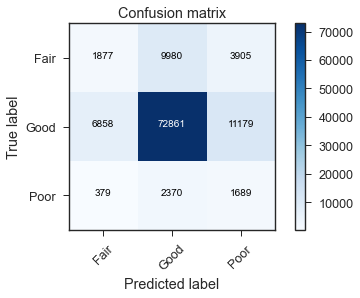

In [184]:

plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [50]:
y_train.value_counts(normalize=True)

Good    0.818180
Fair    0.141876
Poor    0.039944
Name: health, dtype: float64

In [69]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes object with prior probabilities of each class
gnb = GaussianNB(priors=[0.14, 0.82, 0.04])

# Train model
ganaba = gnb.fit(X_train, y_train)

In [70]:
#Predict the response for test dataset
y_pred_gnb = ganaba.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_gnb))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_gnb, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_gnb, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_gnb, average='weighted'))

Test Accuracy score:  0.6456281841257269
Test F1 score:  0.682553879509052
Test Recall score:  0.6456281841257269
Test Precision score:  0.732261755168556


In [65]:
from sklearn.naive_bayes import MultinomialNB

# Create Multinomial Naive Bayes object with prior probabilities of each class
mnb = MultinomialNB(class_prior=[0.14, 0.82, 0.04])

# Train model
manaba = mnb.fit(X_train, y_train)

In [66]:
#Predict the response for test dataset
y_pred_mnb = manaba.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_mnb))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_mnb, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_mnb, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_mnb, average='weighted'))

Test Accuracy score:  0.8088894489549767
Test F1 score:  0.749654333086884
Test Recall score:  0.8088894489549767
Test Precision score:  0.7304767288052713


In [67]:
cm2 = confusion_matrix(y_test, y_pred_mnb)
classes = ['Fair', 'Good', 'Poor']

Confusion Matrix, without normalization
[[  736 14583   443]
 [ 1389 88778   731]
 [  275  3811   352]]


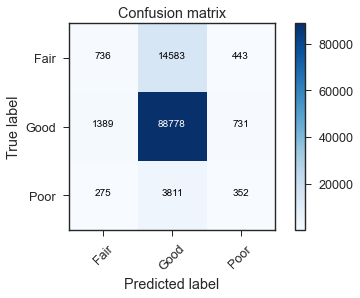

In [68]:
plot_confusion_matrix(cm2, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [71]:
from sklearn.naive_bayes import BernoulliNB

# Create Bernoulli Naive Bayes object with prior probabilities of each class
bnb = BernoulliNB(class_prior=[0.14, 0.82, 0.04])

# Train model
banaba = bnb.fit(X_train, y_train)

In [73]:
#Predict the response for test dataset
y_pred_bnb = banaba.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb, average='weighted'))

Test Accuracy score:  0.8120758249473438
Test F1 score:  0.7502095775193537
Test Recall score:  0.8120758249473438
Test Precision score:  0.7332008191274813


In [88]:
cm3 = confusion_matrix(y_test, y_pred_bnb)
classes = ['Fair', 'Good', 'Poor']

Confusion Matrix, without normalization
[[  733 14739   290]
 [ 1410 89205   283]
 [  264  3892   282]]


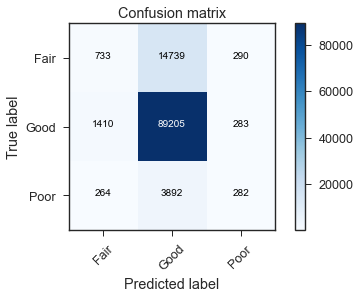

In [89]:
plot_confusion_matrix(cm3, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [94]:
# downsample majority
good_downsampled = resample(good,
                                replace = False, # sample without replacement
                                n_samples = len(fair), # match minority n
                                random_state = 42) # reproducible results

# downsample majority
poor_upsampled = resample(poor,
                                replace = True, # sample with replacement
                                n_samples = len(fair), # match minority n
                                random_state = 42) # reproducible results

In [96]:
# combine minority and downsampled majority
resampled = pd.concat([good_downsampled, fair, poor_upsampled])

# checking counts
resampled.health.value_counts()

Poor    47286
Fair    47286
Good    47286
Name: health, dtype: int64

In [97]:
# trying logistic regression again with the balanced dataset
y_train_resample = resampled.health
X_train_resample = resampled.drop('health', axis=1)

In [147]:
from sklearn.naive_bayes import BernoulliNB

# Create Bernoulli Naive Bayes object with prior probabilities of each class
bnb_down = BernoulliNB(class_prior=[0.14, 0.82, 0.04], alpha=1, fit_prior=True, binarize=.5)

# Train model
banaba_down = bnb_down.fit(X_train_resample, y_train_resample)

In [148]:
#Predict the response for test dataset
y_pred_bnb_down = banaba_down.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb_down))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb_down, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb_down, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb_down, average='weighted'))

Test Accuracy score:  0.8112207240454373
Test F1 score:  0.7508273407993287
Test Recall score:  0.8112207240454373
Test Precision score:  0.7333759058550285


Confusion Matrix, without normalization
[[  818 14667   277]
 [ 1601 89032   265]
 [  298  3865   275]]


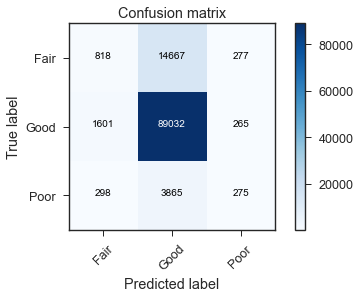

In [149]:
cm4 = confusion_matrix(y_test, y_pred_bnb_down)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm4, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [158]:
params_nb = {
    'class_prior': [[0.14, 0.82, 0.04], [0.15, 0.8, 0.05], [0.175, 0.75, 0.075], [0.2, 0.7, 0.1]],
    'alpha': [.001*10**i for i in range(5)],
    'fit_prior': [True, False],
    'binarize': [.1*i for i in range(4)]
}

In [166]:
#create a grid search object and fit it to the data
bnb_cv = BernoulliNB()
CV_bnb = GridSearchCV(bnb_cv, params_nb, scoring='f1_weighted', n_jobs=-1, verbose=2)
CV_bnb.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  9.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'binarize': [0.0, 0.1, 0.2, 0.30000000000000004],
                         'class_prior': [[0.14, 0.82, 0.04], [0.15, 0.8, 0.05],
                                         [0.175, 0.75, 0.075],
                                         [0.2, 0.7, 0.1]],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [167]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(CV_bnb.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(CV_bnb.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(CV_bnb.best_estimator_)

0.7510988785035144
{'alpha': 0.001, 'binarize': 0.0, 'class_prior': [0.175, 0.75, 0.075], 'fit_prior': True}
BernoulliNB(alpha=0.001, binarize=0.0, class_prior=[0.175, 0.75, 0.075],
            fit_prior=True)


In [168]:
#Predict the response for test dataset
y_pred_bnb_cv = CV_bnb.best_estimator_.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb_cv))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb_cv, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb_cv, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb_cv, average='weighted'))

Test Accuracy score:  0.8025256980323678
Test F1 score:  0.749820497947262
Test Recall score:  0.8025256980323678
Test Precision score:  0.7270121033620303


Normalized confusion matrix
[[0.0581779  0.90343865 0.03838345]
 [0.02382891 0.96579683 0.01037427]
 [0.06466877 0.83325822 0.10207301]]


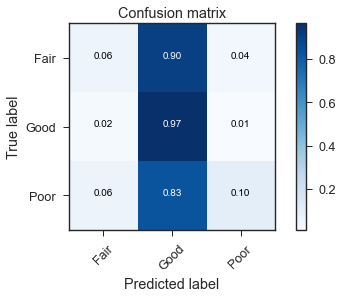

In [183]:
cm5 = confusion_matrix(y_test, y_pred_bnb_cv)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm5, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [218]:
# with open('data/best_model_0526.pickle', 'wb') as f:
#     pickle.dump(CV_forest.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [390]:
with open('data/best_model_0526.pickle', 'rb') as file:
    CV_forest_best = pickle.load(file)

In [391]:
#Predict the response for test dataset
y_pred_forest_best = CV_forest_best.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_best))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_best, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_best, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_best, average='weighted'))

ValueError: Number of features of the model must match the input. Model n_features is 125 and input n_features is 217 

In [ ]:
import math

_REPLACE = 'replace'
_DROP = 'drop'
_DROP_SAMPLES = 'drop_samples'
_DROP_FEATURES = 'drop_features'
_SKIP = 'skip'
_DEFAULT_REPLACE_VALUE = 0.0

def conditional_entropy(x,
                        y,
                        nan_strategy=_REPLACE,
                        nan_replace_value=_DEFAULT_REPLACE_VALUE,
                        log_base: float = math.e):

    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

In [ ]:
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [ ]:
theils_u(trees_full, trees_full)

In [ ]:
# params_knn = {
#     'n_neighbors': range(1,21,2),
#     'weights': ['uniform', 'distance'],
# #     'algorithm': ['ball_tree', 'kd_tree', 'brute'],
#     'p': range(1,4)
# }

In [ ]:
# CV_knn_van = GridSearchCV(KNeighborsClassifier(), params_knn, n_jobs=-1, scoring='accuracy', verbose=1)

# CV_knn_van.fit(X_train_van, y_train_van)

In [ ]:
# ### Identify the best params 
# print(CV_knn_van.best_estimator_)

# #Identify the best score during fitting with cross-validation
# print(CV_knn_van.best_score_)

In [ ]:
# #predict on the test set
# y_pred_knn_van = CV_knn_van.best_estimator_.predict(X_test_van)

# # checking metrics
# print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_knn_van))
# print('Test Precision score: ', precision_score(y_test_van, y_pred_knn_van))
# print('Test Recall score: ', recall_score(y_test_van, y_pred_knn_van))
# print('Test F1 score: ', f1_score(y_test_van, y_pred_knn_van))

In [ ]:
param_grid = { 
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [.0001, .001, .01, .1, 1.0, 10.0, 100.0],
    'solver': ['sag', 'saga', 'liblinear'],
}

In [ ]:
van_weight = LogisticRegression(class_weight='balanced', multi_class='multinomial')
van_weight.fit(X_train_van, y_train_van)

#predict on the test set
y_pred_van_weight = van_weight.predict(X_test_van)

In [ ]:
# checking metrics
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_van_weight))
print('Test Precision score: ', precision_score(y_test_van, y_pred_van_weight, average='weighted'))
print('Test Recall score: ', recall_score(y_test_van, y_pred_van_weight, average='weighted'))
print('Test F1 score: ', f1_score(y_test_van, y_pred_van_weight, average='weighted'))

In [ ]:
#create a grid search object and fit it to the data
CV_van_weight = GridSearchCV(LogisticRegression(class_weight='balanced'),
                      param_grid, n_jobs=-1, scoring='accuracy', verbose=2)

CV_van_weight.fit(X_train_van, y_train_van)

In [ ]:
### Identify the best params 
print(CV_van_weight.best_estimator_)

#Identify the best score during fitting with cross-validation
print(CV_van_weight.best_score_)

In [ ]:
#predict on the test set
y_pred_van_weight = CV_van_weight.best_estimator_.predict(X_test_van)

# checking metrics
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_van_weight))
print('Test Precision score: ', precision_score(y_test_van, y_pred_van_weight))
print('Test Recall score: ', recall_score(y_test_van, y_pred_van_weight))
print('Test F1 score: ', f1_score(y_test_van, y_pred_van_weight))

In [ ]:
from sklearn.svm import SVC

# Create support vector classifier
svc = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=0)

# Train classifier
model = svc.fit(X_train, y_train)

In [ ]:
#Predict the response for test dataset
y_pred_svc = model.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_svc))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_svc, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_svc, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_svc, average='weighted'))

In [ ]:
trees[trees.nta == 'QN17'].iloc[:, 10:].head()

In [ ]:
print(len(trees.cb_num.unique()))
trees.cb_num.unique()

In [ ]:
print(len(trees.nta.unique()))
trees.nta.unique()

In [ ]:
trees.iloc[:, 10:].head(10)

In [ ]:
trees.spc_common.value_counts().head(10).keys()

In [ ]:
trees_most_pop = trees[trees.spc_common.isin(['London planetree', 'honeylocust', 'Callery pear', 'pin oak',
       'Norway maple', 'littleleaf linden', 'cherry', 'Japanese zelkova',
       'ginkgo', 'Sophora'])]
trees_most_pop.head()

In [ ]:
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack()

In [ ]:
# print('Paycode 1 Summary')

# print('\n')
# print(df_train.groupby(['pay_1_bin','default']).pay_1_bin.count().unstack())

# Passenger class visualization
species_health = trees_most_pop.groupby('spc_common').health.value_counts(normalize=True).unstack().head(10)
p1 = species_health.plot(kind = 'bar', stacked = True, 
                   title = 'Paycodes Binned: Defaulters vs Non-Defaulters', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Paycode 1')
p1.set_ylabel('# Users')
p1.legend(['Fair','Good', 'Poor'])
plt.show()

In [ ]:
trees[trees.spc_common == 'London planetree'].health.value_counts(normalize=True)

In [ ]:
trees.groupby('spc_common').health.value_counts(normalize=True)

In [ ]:
trees.columns

In [ ]:
trees.trunk_light.unique()

In [ ]:
trees.problems.value_counts()

In [ ]:
trees.shape

In [ ]:
trees.columns

In [ ]:
len(trees.council_dist.unique())

In [ ]:
len(trees.tree_dbh.unique())

In [ ]:
len(trees.block_id.unique())

In [ ]:
trees.health.value_counts()

In [ ]:
trees.health.value_counts(normalize=True)

In [ ]:
trees.health.isna().sum()

In [ ]:
trees.status.value_counts()

In [ ]:
trees[trees.health.isna()].head(20)

In [ ]:
trees.columns

In [ ]:
trees.curb_loc.unique()

In [ ]:
trees.borocode.value_counts()

In [ ]:
trees.drop(columns=['status'], axis=1)